# Imports

In [1]:
# Python
import time

# Data Analysis and Pre-Processing
import numpy as np
import pandas as pd
import statistics as stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Features Analysis 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from skfeature.function.similarity_based import fisher_score

# Training
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score, f1_score, precision_score, recall_score, plot_confusion_matrix

# Imports Adjustments
np.random.seed(42)
plt.rcParams["figure.figsize"] = (12,6)

# Data Gathering and Preprocessing

## Load the Data

In [2]:
# Load the data with tab-separation
raw_data = pd.read_csv("./data/Dmel_matrix__pml.txt", delimiter="\t", header=None)

# Convert to CSV
raw_data.to_csv()

# Add column names
columns = ["ID"] + [f"feature_{i + 1}" for i in range(raw_data.shape[1]-2)] + ["Target"]
raw_data.columns = columns

print("Dataset Loaded\n")
print(raw_data.head())

Dataset Loaded

           ID  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  Refseq_001         31         44          2          3          0   
1  Refseq_002         13         22          0          2          0   
2  Refseq_003         62         94          4         12          4   
3  Refseq_004         11          8          2          2          2   
4  Refseq_005         41         78          0          3          0   

   feature_6  feature_7  feature_8  feature_9  ...  feature_20  feature_21  \
0          7         10          4          0  ...       0.010      -0.621   
1         13         21          2         16  ...       0.270       0.012   
2          3          9          0          7  ...       0.779       0.490   
3         53         93         27         35  ...       0.000       0.000   
4          0          0          0          0  ...      -0.526      -0.502   

   feature_22  feature_23  feature_24  feature_25  feature_26  feature_27  \
0    

## Check Missing Data

In [3]:
# Check if data has missing values
print(f"Total NaN values: {raw_data.isnull().sum().sum()}")

Total NaN values: 0


## Initial Analysis

In [4]:
# Check Unique Datatypes of the columns
raw_data.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

In [5]:
# Describe
raw_data.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,Target
count,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,...,417.000000,417.000000,417.000000,417.00000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000
mean,21.597122,22.340528,4.354916,2.393285,1.482014,12.364508,13.431655,3.966427,6.527578,2.021583,...,0.118175,0.119197,0.165029,0.05371,0.067506,0.080122,0.067403,0.025832,0.002837,0.498801
std,20.696195,21.204343,4.346604,2.790567,2.201461,25.463426,26.783153,8.046967,13.540176,4.819034,...,0.565199,0.519949,0.607271,0.27631,0.503606,0.457504,0.351611,0.520642,0.602051,0.500599
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.823000,-1.952000,-2.506000,-0.95600,-2.805000,-1.396000,-1.333000,-1.832000,-2.872000,0.000000
25%,5.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.115000,-0.087000,-0.063000,-0.05100,-0.117000,-0.140000,-0.113000,-0.179000,-0.234000,0.000000
50%,15.000000,16.000000,4.000000,1.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.017000,0.019000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33.000000,32.000000,6.000000,4.000000,2.000000,13.000000,13.000000,4.000000,6.000000,2.000000,...,0.393000,0.435000,0.434000,0.14700,0.346000,0.288000,0.200000,0.242000,0.163000,1.000000
max,128.000000,134.000000,28.000000,21.000000,14.000000,215.000000,224.000000,72.000000,104.000000,42.000000,...,4.583000,2.723000,3.841000,1.23500,2.153000,3.083000,1.352000,3.562000,2.618000,1.000000


## Get Dependent(Target) and Independent(Features) Variables

In [6]:
# Capture the Dependent and Independent Variable
features = raw_data.iloc[:, 1:-1].astype("float64")  # Independent Varibale with 28 features
targets = raw_data.iloc[:, -1]  # Dependent Variable with 2 classes

print(f"Features Shape: {features.shape}")
print(f"Target Shape: {targets.shape}")

Features Shape: (417, 28)
Target Shape: (417,)


## Scale the Data

In [7]:
# Scale the Values using MinMaxScaler
features_scaler = MinMaxScaler()
scaled_features = features_scaler.fit_transform(features)

print(f"Minimum of features is: {scaled_features.min()}")
print(f"Maximum of features is: {scaled_features.max()}")

Minimum of features is: 0.0
Maximum of features is: 1.0000000000000002


# Features Analysis

## Dimensionality Reduction to Visualize the Data

In [8]:
# Create a dataframe to work with

# Create Column Names for features
features_column_names = [f"feature_{i+1}" for i in range(scaled_features.shape[1])]

# Create a dataframe for plotting convenience containing features and targets
plotting_dataframe = pd.DataFrame(scaled_features, columns=features_column_names)
plotting_dataframe["target"] = targets

# Cast targets to dtype("str") for plotting convenience
plotting_dataframe["label"] = plotting_dataframe["target"].apply(lambda i: str(i))

plotting_dataframe.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,target,label
0,0.242188,0.328358,0.071429,0.142857,0.000000,0.032558,0.044643,0.055556,0.000000,0.000000,...,0.284706,0.297778,0.067549,0.576039,0.426434,0.407821,0.050797,0.190710,1,1
1,0.101562,0.164179,0.000000,0.095238,0.000000,0.060465,0.093750,0.027778,0.153846,0.047619,...,0.420107,0.400977,0.358284,0.622428,0.294039,0.477840,0.369855,0.500546,1,1
2,0.484375,0.701493,0.142857,0.571429,0.285714,0.013953,0.040179,0.000000,0.067308,0.000000,...,0.522353,0.445407,0.395710,0.647842,0.262112,0.424581,0.272710,0.428233,1,1
3,0.085938,0.059701,0.071429,0.095238,0.142857,0.246512,0.415179,0.375000,0.336538,0.309524,...,0.417540,0.394832,0.436330,0.565752,0.311677,0.496462,0.339637,0.523133,1,1
4,0.320312,0.582090,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.310160,0.300772,0.282976,0.435861,0.225720,0.349348,0.235261,0.446448,1,1


### PCA: Principle Component Analysis

In [9]:
pca_object = PCA(n_components=3)
pca_results = pca_object.fit_transform(plotting_dataframe.iloc[:, :-2])

# Add PCA Results to the plotting dataframe
for i in range(pca_results.shape[1]):
    plotting_dataframe[f"PCA_{i+1}"] = pca_results[:, i]
    
# Get Variations per principal component
variations_per_pca = pca_object.explained_variance_ratio_.tolist() 
print(f"Explained variation per principal component: {variations_per_pca}")
    

Explained variation per principal component: [0.34415506522758776, 0.14905326374273026, 0.11847124253214097]


### t-SNE: T-Distributed Stochastic Neighboring Entities

In [10]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(plotting_dataframe.iloc[:, :-2])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

# Add t-SNE Results to the plotting dataframe
for i in range(tsne_results.shape[1]):
    plotting_dataframe[f"t-SNE_{i+1}"] = pca_results[:, i]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 417 samples in 0.000s...
[t-SNE] Computed neighbors for 417 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 417 / 417
[t-SNE] Mean sigma: 0.296661
[t-SNE] KL divergence after 250 iterations with early exaggeration: 104.058212
[t-SNE] KL divergence after 300 iterations: 3.321068
t-SNE done! Time elapsed: 0.8155279159545898 seconds


### Plots

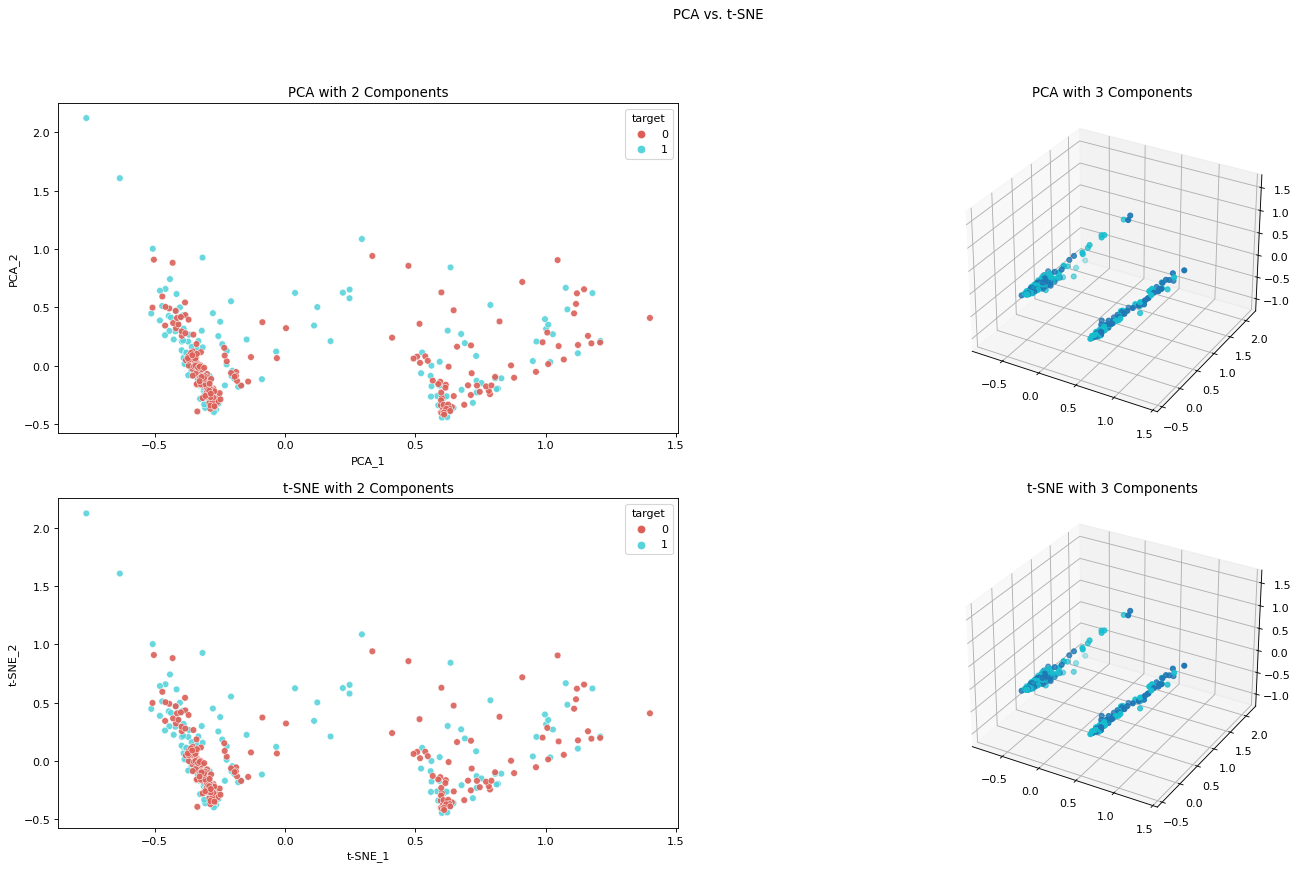

In [11]:
fig = plt.figure(figsize=(22, 12), dpi=80)
fig.suptitle("PCA vs. t-SNE")

# PCA with 2 Components
ax = fig.add_subplot(2, 2, 1)
ax.title.set_text("PCA with 2 Components")
sns.scatterplot(
    x="PCA_1", y="PCA_2",
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=plotting_dataframe,
    legend="full",
    alpha=0.9,
    ax=ax
)

# PCA with 3 Components
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.title.set_text("PCA with 3 Components")
ax.scatter(
    xs=plotting_dataframe["PCA_1"], 
    ys=plotting_dataframe["PCA_2"], 
    zs=plotting_dataframe["PCA_3"], 
    c=plotting_dataframe["target"], 
    cmap='tab10',
)

# t-SNE with 2 Components
ax = fig.add_subplot(2, 2, 3)
ax.title.set_text("t-SNE with 2 Components")
sns.scatterplot(
    x="t-SNE_1", y="t-SNE_2",
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=plotting_dataframe,
    legend="full",
    alpha=0.9,
    ax=ax
)

# t-SNE with 3 Components
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.title.set_text("t-SNE with 3 Components")
ax.scatter(
    xs=plotting_dataframe["t-SNE_1"], 
    ys=plotting_dataframe["t-SNE_2"], 
    zs=plotting_dataframe["t-SNE_3"], 
    c=plotting_dataframe["target"], 
    cmap='tab10',
)
plt.show()

## Filter Methods

### Information Gain
Information gain calculates the reduction in entropy from the transformation of a dataset. It can be used for feature selection by evaluating the Information gain of each variable in the context of the target variable.

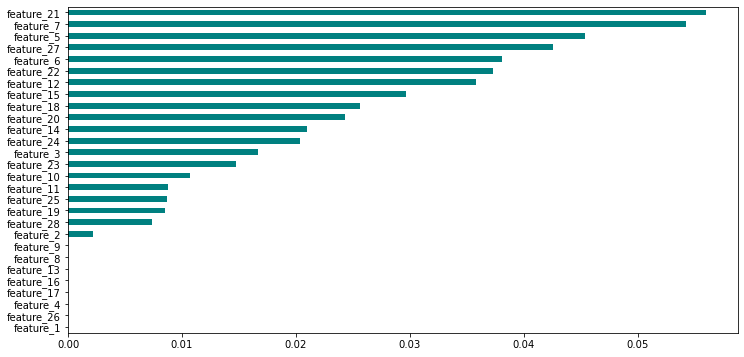

In [12]:
information_gain = mutual_info_classif(
    X=features.values,
    y=targets.values,
    discrete_features=False,
    n_neighbors=3,
)
information_gain_fi = pd.Series(information_gain, features.columns)
information_gain_fi.sort_values(inplace=True)
information_gain_fi.plot(kind='barh', color='teal')
plt.show()

### Fisher's Score

Fisher score is one of the most widely used supervised feature selection methods. The algorithm which we will use returns the ranks of the variables based on the fisher’s score in descending order. We can then select the variables as per the case.


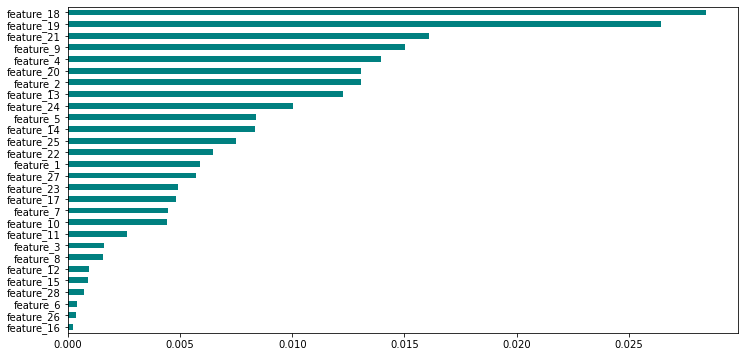

In [13]:
fisher_ranks = fisher_score.fisher_score(X=features.values, y=targets.values)
fisher_score_fi = pd.Series(fisher_ranks, features.columns)
fisher_score_fi.sort_values(inplace=True)
fisher_score_fi.plot(kind='barh', color='teal')
plt.show()

### Feature Selection Based on Analysis

In [14]:
# Set threshold for feature selection
ig_threshold = 0.01
fish_threshold = 0.005

# Get feature names from both strategies
information_gain_selected_features = set(information_gain_fi[information_gain_fi >= ig_threshold].index.tolist())
fishers_score_selected_features = set(fisher_score_fi[fisher_score_fi >= fish_threshold].index.tolist())

# Find the Common feature
selected_features = information_gain_selected_features.intersection(fishers_score_selected_features)
selected_features

{'feature_14',
 'feature_18',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_24',
 'feature_27',
 'feature_5'}

# Data Prepration for training

## Train Test Split

In [15]:
# Split the data in train_set and test_set
X_train, X_test, y_train, y_test = train_test_split(features[selected_features].values, targets.values, test_size=0.2)

print(f"Training features shape: {X_train.shape}")
print(f"Training Labels shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing Labels shape: {y_test.shape}")

Training features shape: (333, 8)
Training Labels shape: (333,)
Testing features shape: (84, 8)
Testing Labels shape: (84,)


# Training

### Logistic Regression


----------Training Logistic Regression----------

Accuracy Score         :       0.52
Avarage Precision Score:       0.45
f1 Score               :       0.52
Precision Score        :       0.46
Recall Score           :       0.61



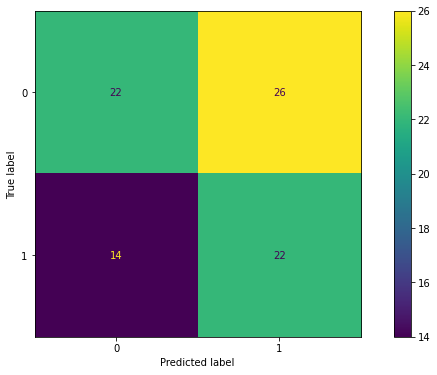

In [16]:
# 1) Logistic Regression

classifier = LogisticRegression(C=1.0, penalty="l2", max_iter=1000)
print()
print("----------Training Logistic Regression----------")
print()
classifier.fit(X_train, y_train)

# Pridiciton of Testset
y_pred = classifier.predict(X_test)

# Confusion Matrix
acc_score = accuracy_score(y_test, y_pred)
apc = average_precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
ps = precision_score(y_test, y_pred)
rs = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('{:<23}: {:>10.2f}'.format('Accuracy Score', acc_score), sep='')
print('{:<23}: {:>10.2f}'.format('Avarage Precision Score', apc), sep='')
print('{:<23}: {:>10.2f}'.format('f1 Score', f1), sep='')
print('{:<23}: {:>10.2f}'.format('Precision Score', ps), sep='')
print('{:<23}: {:>10.2f}'.format('Recall Score', rs), sep='')
print()

plot_confusion_matrix(classifier, X_test, y_test)
plt.show()

### k-Nearest Neighbors


----------Training k-NN----------

Accuracy Score         :       0.58
Avarage Precision Score:       0.48
f1 Score               :       0.56
Precision Score        :       0.51
Recall Score           :       0.61



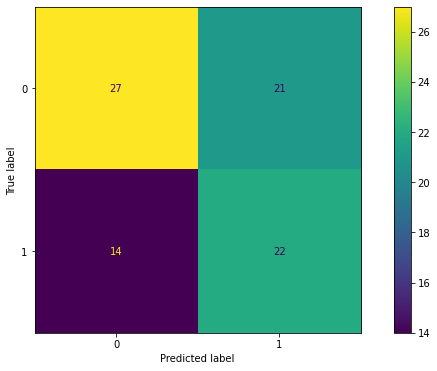

In [17]:
# 2) k-NN

classifier = KNeighborsClassifier(n_neighbors=1, leaf_size=1, p=1)
print()
print("----------Training k-NN----------")
print()
classifier.fit(X_train, y_train)

# Pridiciton of Testset
y_pred = classifier.predict(X_test)

# Confusion Matrix
acc_score = accuracy_score(y_test, y_pred)
apc = average_precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
ps = precision_score(y_test, y_pred)
rs = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('{:<23}: {:>10.2f}'.format('Accuracy Score', acc_score), sep='')
print('{:<23}: {:>10.2f}'.format('Avarage Precision Score', apc), sep='')
print('{:<23}: {:>10.2f}'.format('f1 Score', f1), sep='')
print('{:<23}: {:>10.2f}'.format('Precision Score', ps), sep='')
print('{:<23}: {:>10.2f}'.format('Recall Score', rs), sep='')
print()

plot_confusion_matrix(classifier, X_test, y_test)
plt.show()

### Support Vector Machine (SVM)


----------Training SVM----------

Accuracy Score         :       0.57
Avarage Precision Score:       0.47
f1 Score               :       0.51
Precision Score        :       0.50
Recall Score           :       0.53



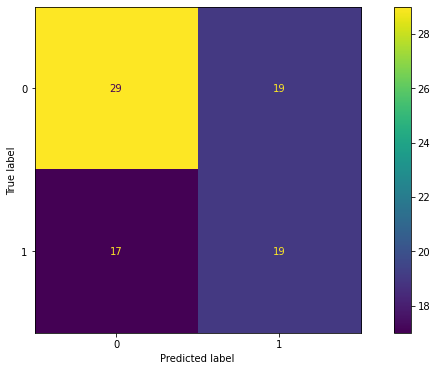

In [18]:
# 3) Support Vector Mahcine (SVM)
classifier = SVC(C=100, gamma=0.001)
print()
print("----------Training SVM----------")
print()
classifier.fit(X_train, y_train)

# Pridiciton of Testset
y_pred = classifier.predict(X_test)

# Confusion Matrix
acc_score = accuracy_score(y_test, y_pred)
apc = average_precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
ps = precision_score(y_test, y_pred)
rs = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('{:<23}: {:>10.2f}'.format('Accuracy Score', acc_score), sep='')
print('{:<23}: {:>10.2f}'.format('Avarage Precision Score', apc), sep='')
print('{:<23}: {:>10.2f}'.format('f1 Score', f1), sep='')
print('{:<23}: {:>10.2f}'.format('Precision Score', ps), sep='')
print('{:<23}: {:>10.2f}'.format('Recall Score', rs), sep='')
print()

plot_confusion_matrix(classifier, X_test, y_test)
plt.show()

### Decision Tree


----------Training Decision Trees----------

Accuracy Score         :       0.64
Avarage Precision Score:       0.53
f1 Score               :       0.62
Precision Score        :       0.57
Recall Score           :       0.69



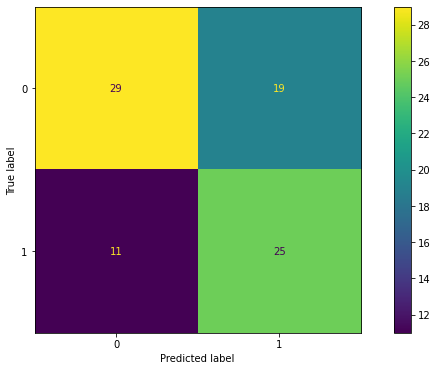

In [19]:
# 4) Decision Trees
classifier = DecisionTreeClassifier(max_leaf_nodes=12)
print()
print("----------Training Decision Trees----------")
print()
classifier.fit(X_train, y_train)

# Pridiciton of Testset
y_pred = classifier.predict(X_test)

# Confusion Matrix
acc_score = accuracy_score(y_test, y_pred)
apc = average_precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
ps = precision_score(y_test, y_pred)
rs = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('{:<23}: {:>10.2f}'.format('Accuracy Score', acc_score), sep='')
print('{:<23}: {:>10.2f}'.format('Avarage Precision Score', apc), sep='')
print('{:<23}: {:>10.2f}'.format('f1 Score', f1), sep='')
print('{:<23}: {:>10.2f}'.format('Precision Score', ps), sep='')
print('{:<23}: {:>10.2f}'.format('Recall Score', rs), sep='')
print()

plot_confusion_matrix(classifier, X_test, y_test)
plt.show()

### Random Forest


----------Training Random Forest----------

Accuracy Score         :       0.67
Avarage Precision Score:       0.55
f1 Score               :       0.66
Precision Score        :       0.59
Recall Score           :       0.75



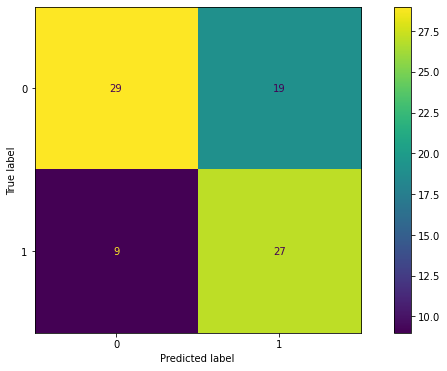

In [20]:
# 5) Random Forest
classifier = RandomForestClassifier(bootstrap=False, max_depth=10, max_features="sqrt", min_samples_leaf=1, min_samples_split=10, n_estimators=400)
print()
print("----------Training Random Forest----------")
print()
classifier.fit(X_train, y_train)

# Pridiciton of Testset
y_pred = classifier.predict(X_test)

# Confusion Matrix
acc_score = accuracy_score(y_test, y_pred)
apc = average_precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
ps = precision_score(y_test, y_pred)
rs = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('{:<23}: {:>10.2f}'.format('Accuracy Score', acc_score), sep='')
print('{:<23}: {:>10.2f}'.format('Avarage Precision Score', apc), sep='')
print('{:<23}: {:>10.2f}'.format('f1 Score', f1), sep='')
print('{:<23}: {:>10.2f}'.format('Precision Score', ps), sep='')
print('{:<23}: {:>10.2f}'.format('Recall Score', rs), sep='')
print()

plot_confusion_matrix(classifier, X_test, y_test)
plt.show()

### Naive Bayes


----------Training Naive Bayes----------

Accuracy Score         :       0.49
Avarage Precision Score:       0.44
f1 Score               :       0.55
Precision Score        :       0.44
Recall Score           :       0.72



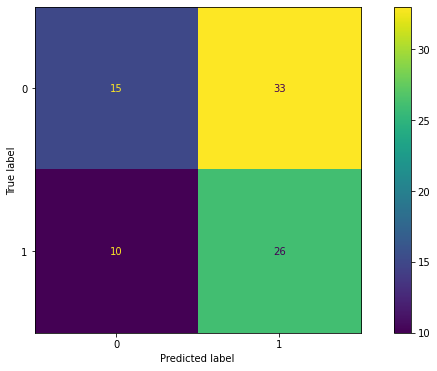

In [21]:
# 6) Naive Baye
classifier = GaussianNB()
print()
print("----------Training Naive Bayes----------")
print()
classifier.fit(X_train, y_train)

# Pridiciton of Testset
y_pred = classifier.predict(X_test)

# Confusion Matrix
acc_score = accuracy_score(y_test, y_pred)
apc = average_precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
ps = precision_score(y_test, y_pred)
rs = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('{:<23}: {:>10.2f}'.format('Accuracy Score', acc_score), sep='')
print('{:<23}: {:>10.2f}'.format('Avarage Precision Score', apc), sep='')
print('{:<23}: {:>10.2f}'.format('f1 Score', f1), sep='')
print('{:<23}: {:>10.2f}'.format('Precision Score', ps), sep='')
print('{:<23}: {:>10.2f}'.format('Recall Score', rs), sep='')
print()

plot_confusion_matrix(classifier, X_test, y_test)
plt.show()

# Scratchpad

In [22]:
# models = []
# models.append(('LR', LogisticRegression()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('SVM', SVC()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('RF', RandomForestClassifier()))
# models.append(('NB', GaussianNB()))

In [23]:
# results = []
# names = []
# scoring = 'accuracy'
# for name, model in models:
# 	kfold = KFold(n_splits=7, random_state=seed)
# 	cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
# 	results.append(cv_results)
# 	names.append(name)
# 	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
# 	print(msg)
# # boxplot algorithm comparison
# fig = plt.figure()
# fig.suptitle('Algorithm Comparison')
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# plt.savefig('Result.png')

In [24]:
# csv_dict = dict()

# for name, result in zip(names, results):
#     if name not in csv_dict.keys():
#         stats = []
#         stats.append(min(result))
#         stats.append(statistics.median(result))
#         stats.append(max(result))
#         stats.append(statistics.variance(result))
#         stats.append(statistics.stdev(result))
        
#         csv_dict[name] = stats